<a href="https://colab.research.google.com/github/haykalaul/garbage-classification/blob/main/_t_Garbage_Classification_5_Classes_%7C97_5_%7C0_097%7C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: Garbage Classification (5 classes)
- **Nama:** 1.Haykal Aulil Albab 2.Putri Endang Lestari 3. Septi Kirana D.L.


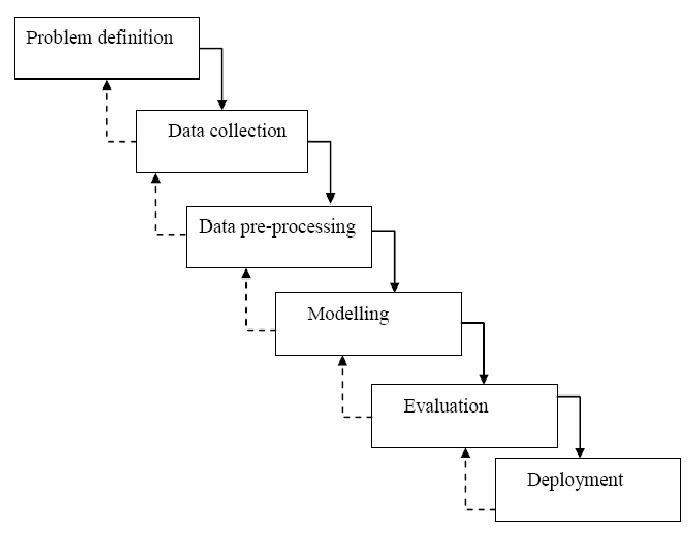

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
mostafaabla_garbage_classification_path = kagglehub.dataset_download('mostafaabla/garbage-classification')

print('Data source import complete.')


Using Colab cache for faster access to the 'garbage-classification' dataset.
Data source import complete.


## Import Semua Packages/Library yang Digunakan

In [ ]:
#GENERAL
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import time
from tqdm import tqdm

#PATH PROCESS
import os
import glob
from pathlib import Path
import shutil

#IMAGE PROCESS
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

#SCALER & TRANSFORMATION
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

#ACCURACY CONTROL
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, balanced_accuracy_score, precision_score, recall_score, f1_score, average_precision_score

#OPTIMIZER
from keras.optimizers import RMSprop, Adam, SGD

#MODEL LAYERS
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, \
                                    MaxPooling2D, GlobalAveragePooling2D, SeparableConv2D, ZeroPadding2D, \
                                    Convolution2D, ZeroPadding2D, LSTM, SimpleRNN, GRU, Bidirectional, Permute, \
                                    TimeDistributed
from tensorflow.keras.applications import VGG16, VGG19, InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import models
from keras import layers
import tensorflow as tf
from keras.utils import plot_model
import keras
from tensorflow.keras.models import load_model

#IGNORING WARNINGS
import warnings
warnings.filterwarnings("ignore")

#PLOT TYPE
plt.style.use("classic")

In [ ]:
!pip install tensorflowjs

In [ ]:
print(tf.__version__)

2.19.0


## Data Preparation

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mostafaabla/garbage-classification")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'garbage-classification' dataset.
Path to dataset files: /kaggle/input/garbage-classification


In [ ]:
source_dir = "/kaggle/input/garbage-classification/garbage_classification"

# Destination directory
destination_dir = "/kaggle/working/garbage-classification"

shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)

'/kaggle/working/garbage-classification'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Set-up Env Variable kaggle config & Download Data

In [ ]:
# # Set-up Env Variable for kaggle Config
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Colab Notebooks/Proyek Klasifikasi Gambar'

# # Tentukan path untuk menyimpan dataset
path_to_save = '/content/drive/MyDrive/Colab Notebooks/Proyek Klasifikasi Gambar/Dataset'

# # Buat direktori jika belum ada
os.makedirs(path_to_save, exist_ok=True)

# # Unduh dataset menggunakan perintah kaggle
!kaggle datasets download -d mostafaabla/garbage-classification -p '{path_to_save}'

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [ ]:
# # Ekstrak dataset
#!unzip '{path_to_save}/garbage-classification.zip' -d '{path_to_save}'

# # Hapus file zip jika diperlukan
#os.remove(f'{path_to_save}/garbage-classification.zip')

### Data Loading

In [ ]:
# Definisikan main path
mainPath = "/kaggle/working"

# Gabungkan dengan path dataset
dataPath = mainPath + "/garbage-classification"

In [ ]:
count_all_data = [] # Before Sampling

for subdir in os.listdir(dataPath):
    subdir_path = os.path.join(dataPath, subdir)

    # Pastikan hanya memproses folder
    if os.path.isdir(subdir_path):
        image_files = [f for f in os.listdir(subdir_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        num_images = len(image_files)

        count_all_data.append(num_images)

        print(f"{subdir}: {num_images}")

print(f"\nTotal: {sum(count_all_data)}") # Raw Data

plastic: 865
brown-glass: 607
biological: 985
clothes: 5325
trash: 697
battery: 945
green-glass: 629
paper: 1050
metal: 769
cardboard: 891
white-glass: 775
shoes: 1977

Total: 15515


#### Class mapping becomes more focused

Beberapa kelas memiliki hubungan erat dan bisa digabungkan untuk menyederhanakan klasifikasi dengan mempertimbangkan:  
✅ **Kesamaan material** (misalnya, berbagai jenis kaca bisa digabung).
✅ **Keseimbangan jumlah sampel** agar model tidak terlalu bias ke kelas mayoritas.
✅ **Relevansi dalam pengolahan sampah** (misalnya, bahan daur ulang vs. sampah organik).

**🔹 Opsi Optimal (5 Kelas)**
1. **Fabric-based (Pakaian & Sepatu) →** `clothes + shoes` **(5325 + 1977 = 7302 sampel)**  
2. **Paper-based (Kertas & Kardus) →** `paper + cardboard` **(1050 + 891 = 1941 sampel)**  
3. **Glass (Semua Jenis Kaca) →** `white-glass + brown-glass + green-glass` **(775 + 607 + 629 = 2011 sampel)**  
4. **Recyclable inorganic (Plastik & Logam) →** `plastic + metal` **(865 + 769 = 1634 sampel)**  
5. **Non-recyclable & organic waste (Sampah umum & biologis) →** `trash + biological + battery` **(697 + 985 + 945 = 2627 sampel)**

In [ ]:
category_mapping = {
    "battery": "non-recyclable",  # Masuk ke kategori sampah non-daur ulang
    "biological": "non-recyclable",  # Sampah organik juga di sini
    "trash": "non-recyclable",
    "brown-glass": "glass",
    "green-glass": "glass",
    "white-glass": "glass",
    "cardboard": "paper",
    "paper": "paper",
    "clothes": "fabric",  # Sesuai dengan kategori fabric-based
    "shoes": "fabric",  # Masuk ke fabric juga
    "metal": "recyclable-inorganic",
    "plastic": "recyclable-inorganic"
}

In [ ]:
# Path baru untuk kategori hasil penggabungan
new_dataPath = os.path.join(os.path.dirname(dataPath), "garbage-classification-merged") # new path for the new dataset
os.makedirs(new_dataPath, exist_ok=True)

# Buat folder baru untuk kategori hasil penggabungan jika belum ada
for new_category in set(category_mapping.values()):
    new_category_path = os.path.join(new_dataPath, new_category)
    os.makedirs(new_category_path, exist_ok=True)

In [ ]:
# Counter untuk penamaan file di kategori baru
file_counters = {key: 1 for key in category_mapping.values()}

# Downsampling untuk kategori 'clothes'
clothes_path = os.path.join(dataPath, "clothes")
if os.path.exists(clothes_path):
    clothes_files = os.listdir(clothes_path)

    # Ambil 2500 file secara acak jika jumlahnya lebih besar
    if len(clothes_files) > 2000:
        clothes_files = random.sample(clothes_files, 2000)

# Menyalin file ke folder baru sesuai kategori yang sudah digabungkan
for old_category, new_category in category_mapping.items():
    old_category_path = os.path.join(dataPath, old_category)
    new_category_path = os.path.join(new_dataPath, new_category)

    if os.path.exists(old_category_path):
        # Gunakan hasil sampling untuk kategori 'clothes'
        file_list = os.listdir(old_category_path)
        if old_category == "clothes":
            file_list = clothes_files

        for file_name in file_list:
            old_file_path = os.path.join(old_category_path, file_name)

            if os.path.isfile(old_file_path):  # Pastikan hanya file yang disalin
                # Rename file jika masuk dalam kategori yang digabung
                new_file_name = f"{new_category}{file_counters[new_category]}.jpg"
                file_counters[new_category] += 1

                new_file_path = os.path.join(new_category_path, new_file_name)
                shutil.copy2(old_file_path, new_file_path)  # Gunakan copy2 agar metadata tetap terjaga

        print(f"Semua file dari '{old_category}' disalin ke '{new_category}'.")

print("Penyalinan dan rename selesai.")

Semua file dari 'battery' disalin ke 'non-recyclable'.
Semua file dari 'biological' disalin ke 'non-recyclable'.
Semua file dari 'trash' disalin ke 'non-recyclable'.
Semua file dari 'brown-glass' disalin ke 'glass'.
Semua file dari 'green-glass' disalin ke 'glass'.
Semua file dari 'white-glass' disalin ke 'glass'.
Semua file dari 'cardboard' disalin ke 'paper'.
Semua file dari 'paper' disalin ke 'paper'.
Semua file dari 'clothes' disalin ke 'fabric'.
Semua file dari 'shoes' disalin ke 'fabric'.
Semua file dari 'metal' disalin ke 'recyclable-inorganic'.
Semua file dari 'plastic' disalin ke 'recyclable-inorganic'.
Penyalinan dan rename selesai.


In [ ]:
count_all_data = [] # Before Sampling
for subdir in os.listdir(new_dataPath):
    subdir_path = os.path.join(new_dataPath, subdir)

    # Pastikan hanya memproses folder
    if os.path.isdir(subdir_path):
        image_files = [f for f in os.listdir(subdir_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        num_images = len(image_files)
        count_all_data.append(num_images)
        print(f"{subdir}: {num_images}")

recyclable-inorganic: 1634
paper: 1941
fabric: 3977
glass: 2011
non-recyclable: 2627


In [ ]:
print(f"Total: {sum(count_all_data)}") # combine multiple classes into one unit (count is the same with previous result)

Total: 12190


#### Check the Resolution

In [ ]:
def print_images_resolution(directory, max_images_per_class=10):
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if not os.path.isdir(subdir_path):
            continue

        image_files = [f for f in os.listdir(subdir_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        sampled_files = image_files[:max_images_per_class]  # Ambil maksimal 5 gambar per kelas
        num_images = len(sampled_files)

        print(f"{subdir}: {num_images}")
        total_images += num_images

        unique_sizes = set()  # Reset setiap iterasi kelas
        for img_file in sampled_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

In [ ]:
print_images_resolution(new_dataPath, max_images_per_class=35)

recyclable-inorganic: 35
- (217, 232)
- (235, 214)
- (216, 233)
- (230, 219)
- (225, 225)
- (182, 277)
- (275, 183)
- (193, 261)
- (215, 234)
- (293, 172)
- (199, 253)
- (277, 182)
- (300, 168)
- (512, 384)
- (259, 194)
---------------
paper: 35
- (243, 207)
- (284, 177)
- (300, 151)
- (245, 205)
- (225, 225)
- (198, 254)
- (200, 251)
- (275, 183)
- (189, 267)
- (246, 205)
- (224, 224)
- (282, 179)
- (512, 384)
- (259, 194)
---------------
fabric: 35
- (260, 194)
- (400, 534)
- (370, 136)
- (265, 190)
- (602, 400)
- (400, 463)
- (400, 533)
- (183, 275)
- (533, 400)
- (476, 400)
- (300, 168)
- (400, 435)
- (742, 400)
- (266, 190)
- (226, 151)
- (400, 413)
- (194, 259)
- (225, 225)
- (275, 183)
- (534, 400)
---------------
glass: 35
- (168, 300)
- (214, 236)
- (183, 276)
- (512, 384)
- (200, 252)
- (189, 267)
- (212, 238)
- (194, 260)
- (183, 275)
- (259, 194)
- (224, 224)
- (151, 334)
- (220, 220)
- (171, 294)
- (194, 259)
- (225, 225)
- (256, 197)
- (262, 192)
- (275, 183)
- (245, 206)

#### Check the Labels

In [ ]:
# Folder_Name
pd.DataFrame(os.listdir(new_dataPath),columns=['Folder_Name'])

,Folder_Name
0,recyclable-inorganic
1,paper
2,fabric
3,glass
4,non-recyclable


#### Get the Directory of Every Data

In [ ]:
files = [i for i in glob.glob(new_dataPath + "//*//*")]
np.random.shuffle(files)
labels = [os.path.dirname(i).split("/")[-1] for i in files]
data = zip(files, labels)
dataframe = pd.DataFrame(data, columns = ["Image", "Label"])
dataframe

,Image,Label
0,/kaggle/working/garbage-classification-merged/...,non-recyclable
1,/kaggle/working/garbage-classification-merged/...,recyclable-inorganic
2,/kaggle/working/garbage-classification-merged/...,paper
3,/kaggle/working/garbage-classification-merged/...,non-recyclable
4,/kaggle/working/garbage-classification-merged/...,fabric
...,...,...
12185,/kaggle/working/garbage-classification-merged/...,glass
12186,/kaggle/working/garbage-classification-merged/...,glass
12187,/kaggle/working/garbage-classification-merged/...,recyclable-inorganic
12188,/kaggle/working/garbage-classification-merged/...,non-recyclable


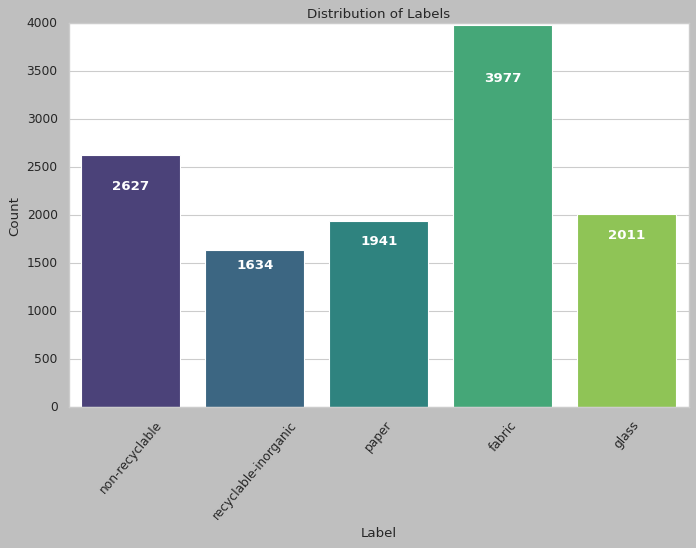

In [ ]:
# Menghitung jumlah setiap label
label_counts = dataframe["Label"].value_counts()

# Membuat plot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
ax = sns.countplot(x=dataframe["Label"], palette="viridis")

# Menambahkan label pada setiap bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()/1.2),
                ha = 'center', va = 'center',
                xytext = (0, 10), textcoords = 'offset points', fontsize=12, fontweight='bold', color='white')

# Menambahkan judul dan label sumbu
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=50)
plt.show()

#### Show The Sample Data

In [ ]:
def show_one_image_per_class(directory):
    classes = [cls for cls in os.listdir(directory) if os.path.isdir(os.path.join(directory, cls))]
    num_classes = len(classes)
    cols = 2
    rows = (num_classes + cols - 1) // cols  # Hitung jumlah baris secara otomatis

    plt.figure(figsize=(20, rows * 5))

    for i, cls in enumerate(classes):
        class_path = os.path.join(directory, cls)
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if not image_files:
            continue
        img_file = random.choice(image_files)

        img_path = os.path.join(class_path, img_file)
        with Image.open(img_path) as img:
            ax = plt.subplot(rows, cols, i + 1)
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(cls, fontsize=14)

    plt.tight_layout()
    plt.show()

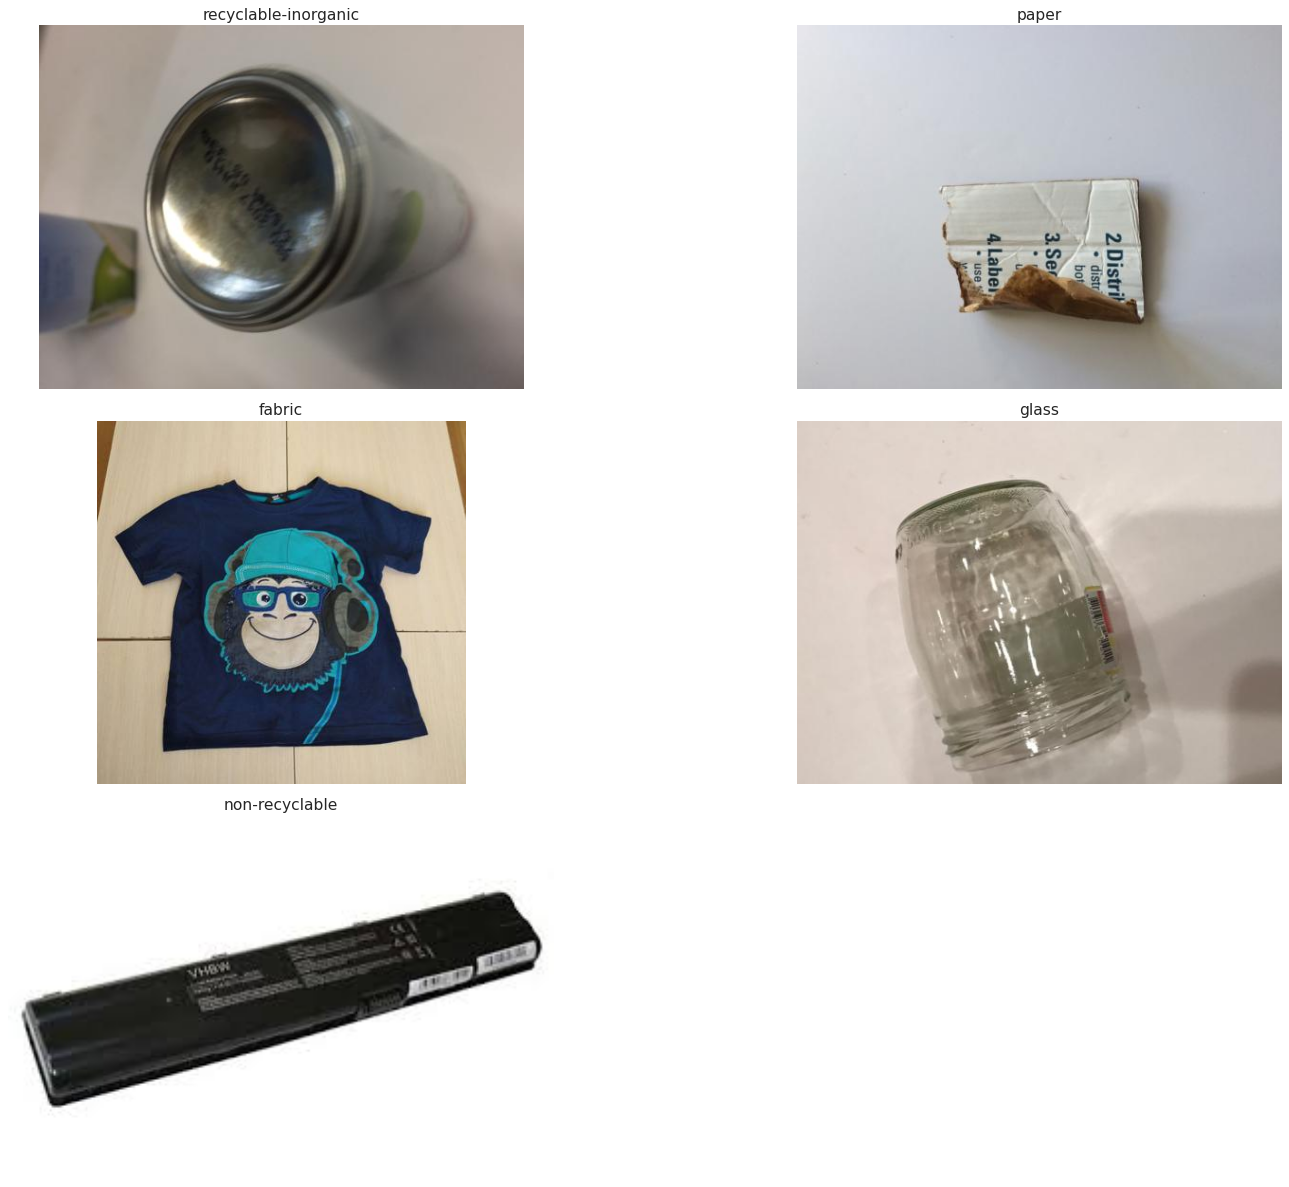

In [ ]:
# Panggil fungsi untuk menampilkan gambar
show_one_image_per_class(new_dataPath)

### Data Preprocessing

#### Split Dataset

In [ ]:
mainPath

'/kaggle/working'

In [ ]:
# Tentukan direktori tujuan untuk train, val, dan test
train_dir = mainPath + "/Dataset/train"
val_dir = mainPath + "/Dataset/val"
test_dir = mainPath + "/Dataset/test"

BATCH_SIZE = 64
TARGET_SIZE = (299, 299)

In [ ]:
# Membaca nama kelas secara otomatis
classes = os.listdir(new_dataPath)
class_indices = {name: index for index, name in enumerate(classes)}

In [ ]:
class_indices

{'recyclable-inorganic': 0,
 'paper': 1,
 'fabric': 2,
 'glass': 3,
 'non-recyclable': 4}

In [ ]:
# Membuat subdirektori untuk setiap kelas dalam folder train, val, dan test
for directory in [train_dir, val_dir, test_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)
    for cls in classes:
        os.makedirs(os.path.join(directory, cls), exist_ok=True)

In [ ]:
# Pastikan seed untuk reprodusibilitas
random.seed(42)

# Fungsi untuk membagi data secara aman (dengan stratifikasi jika memungkinkan)
def safe_train_test_split(images, test_size, stratify_labels=None):
    if stratify_labels is not None and len(set(stratify_labels)) > 1:  # Cek jika ada lebih dari 1 kategori
        return train_test_split(images, test_size=test_size, stratify=stratify_labels, random_state=42)
    else:
        return train_test_split(images, test_size=test_size, random_state=42, shuffle=True)  # Pakai shuffle jika tidak bisa stratifikasi

# Loop untuk setiap kelas
for cls in classes:
    class_path = os.path.join(new_dataPath, cls)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)

        if len(images) < 2:
            print(f"❌ Skip '{cls}', karena hanya {len(images)} gambar (minimal 2 gambar diperlukan untuk stratifikasi)")
            continue  # Lewati kelas yang terlalu kecil

        # Dummy label agar bisa melakukan stratifikasi (misalnya, label berdasarkan nama file)
        labels = [cls] * len(images)  # Semua gambar dalam satu kelas memiliki label yang sama

        # Membagi data
        train_images, temp_images = safe_train_test_split(images, test_size=0.10, stratify_labels=labels)
        val_images, test_images = safe_train_test_split(temp_images, test_size=0.30, stratify_labels=[cls] * len(temp_images))

        # Pastikan direktori tujuan ada
        os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

        # Fungsi untuk memindahkan gambar hanya jika folder masih kosong
        def move_images(image_list, source, destination):
            if len(os.listdir(destination)) == 0:
                for image in image_list:
                    shutil.copy(os.path.join(source, image), os.path.join(destination, image))
                print(f"✅ Data dipindahkan ke '{destination}' dengan jumlah [{len(image_list)}]")
            else:
                print(f"⚠ Data sudah ada di '{destination}', tidak dipindahkan.")

        # Pindahkan gambar ke masing-masing folder
        move_images(train_images, class_path, os.path.join(train_dir, cls))
        move_images(val_images, class_path, os.path.join(val_dir, cls))
        move_images(test_images, class_path, os.path.join(test_dir, cls))

        print("-" * 60)

✅ Data dipindahkan ke '/kaggle/working/Dataset/train/recyclable-inorganic' dengan jumlah [1470]
✅ Data dipindahkan ke '/kaggle/working/Dataset/val/recyclable-inorganic' dengan jumlah [114]
✅ Data dipindahkan ke '/kaggle/working/Dataset/test/recyclable-inorganic' dengan jumlah [50]
------------------------------------------------------------
✅ Data dipindahkan ke '/kaggle/working/Dataset/train/paper' dengan jumlah [1746]
✅ Data dipindahkan ke '/kaggle/working/Dataset/val/paper' dengan jumlah [136]
✅ Data dipindahkan ke '/kaggle/working/Dataset/test/paper' dengan jumlah [59]
------------------------------------------------------------
✅ Data dipindahkan ke '/kaggle/working/Dataset/train/fabric' dengan jumlah [3579]
✅ Data dipindahkan ke '/kaggle/working/Dataset/val/fabric' dengan jumlah [278]
✅ Data dipindahkan ke '/kaggle/working/Dataset/test/fabric' dengan jumlah [120]
------------------------------------------------------------
✅ Data dipindahkan ke '/kaggle/working/Dataset/train/glas

#### Make Sure There is No Data Leakage

In [ ]:
# Membaca nama gambar di setiap folder
train_images = set()
val_images = set()
test_images = set()

# Memeriksa gambar di train, val, dan test folder
for cls in os.listdir(train_dir):
    train_images.update(os.listdir(os.path.join(train_dir, cls)))

for cls in os.listdir(val_dir):
    val_images.update(os.listdir(os.path.join(val_dir, cls)))

for cls in os.listdir(test_dir):
    test_images.update(os.listdir(os.path.join(test_dir, cls)))

# Memeriksa apakah ada tumpang tindih nama gambar antara train, val, dan test
overlap = train_images & val_images | train_images & test_images | val_images & test_images

if overlap:
    print(f"Duplicate images found: {overlap}")
else:
    print("No duplicate images found.")

No duplicate images found.


In [ ]:
# Fungsi untuk menghitung jumlah gambar dalam setiap subfolder
def count_images_in_subfolders(directory):
    total_images = 0
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):  # Pastikan hanya folder yang dihitung
            total_images += len(os.listdir(subdir_path))  # Menghitung gambar di setiap subfolder
    return total_images

In [ ]:
# Menghitung jumlah gambar untuk train, validation, dan test
train_samples = count_images_in_subfolders(train_dir)
validation_samples = count_images_in_subfolders(val_dir)
test_samples = count_images_in_subfolders(test_dir)

# Menampilkan jumlah gambar
print(f"Train samples: {train_samples}")
print(f"Validation samples: {validation_samples}")
print(f"Test samples: {test_samples}\n")

print(f"Total data: {train_samples + validation_samples + test_samples}")
print(f"Total classes: {len(classes)}")

Train samples: 10968
Validation samples: 853
Test samples: 369

Total data: 12190
Total classes: 5


:#### Data Processing and Generator using Keras

In [ ]:
# Membuat ImageDataGenerator untuk preprocessing gambar
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi citra
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Membaca dataset menggunakan flow_from_directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size= TARGET_SIZE,  # Ukuran input model sesuai konfigurasi
    batch_size= BATCH_SIZE,  # Batch size sesuai konfigurasi
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size= TARGET_SIZE,  # Ukuran input model sesuai konfigurasi
    batch_size= BATCH_SIZE,  # Batch size sesuai konfigurasi
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size= TARGET_SIZE,  # Ukuran input model sesuai konfigurasi
    batch_size= BATCH_SIZE,  # Batch size sesuai konfigurasi
    class_mode='categorical'
)

Found 10968 images belonging to 5 classes.
Found 853 images belonging to 5 classes.
Found 369 images belonging to 5 classes.


In [ ]:
# Mendapatkan nama kelas dan membuat mapping ke indeks
class_names = train_generator.class_indices
class_names_list = list(class_names.keys())  # Nama kelas dalam bentuk list
class_indices = {name: index for index, name in enumerate(class_names_list)}

# Mencetak informasi mengenai data training, validation, dan test
print("TRAIN: ")
print("Classes: ", class_names_list)
print("Class Indices: ", class_indices)
print("Image shape: ", train_generator.image_shape)
print("---" * 20)

print("VALIDATION: ")
print("Classes: ", validation_generator.class_indices)
print("Image shape: ", validation_generator.image_shape)
print("---" * 20)

print("TEST: ")
print("Classes: ", test_generator.class_indices)
print("Image shape: ", test_generator.image_shape)

TRAIN: 
Classes:  ['fabric', 'glass', 'non-recyclable', 'paper', 'recyclable-inorganic']
Class Indices:  {'fabric': 0, 'glass': 1, 'non-recyclable': 2, 'paper': 3, 'recyclable-inorganic': 4}
Image shape:  (299, 299, 3)
------------------------------------------------------------
VALIDATION: 
Classes:  {'fabric': 0, 'glass': 1, 'non-recyclable': 2, 'paper': 3, 'recyclable-inorganic': 4}
Image shape:  (299, 299, 3)
------------------------------------------------------------
TEST: 
Classes:  {'fabric': 0, 'glass': 1, 'non-recyclable': 2, 'paper': 3, 'recyclable-inorganic': 4}
Image shape:  (299, 299, 3)


## Modelling

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
def compute_class_weights(train_path):
    files = [i for i in glob.glob(train_path + "//*//*")]
    labels = [os.path.dirname(i).split("/")[-1] for i in files]
    class_labels = sorted(set(labels))
    class_weights = compute_class_weight(class_weight='balanced', classes=np.array(class_labels), y=labels)
    return dict(zip(class_labels, class_weights))

class_weight_dict = compute_class_weights(train_dir)
display(class_weight_dict)

{'fabric': np.float64(0.6129086336965632),
 'glass': np.float64(1.212603648424544),
 'non-recyclable': np.float64(0.9279187817258884),
 'paper': np.float64(1.2563573883161512),
 'recyclable-inorganic': np.float64(1.4922448979591836)}

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# Callback untuk menghentikan training sesuai akurasi yang diinginkan
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy')
        accuracy = logs.get('accuracy')

        if val_accuracy is not None and accuracy is not None:
            if val_accuracy > 0.97 and accuracy > 0.97:  # Akurasi lebih besar dari 95.5%
                print("\nAkurasi dan validasi akurasi sudah > 97%, training dihentikan.")
                self.model.stop_training = True
            else:
                print("\nBelum mencapai akurasi > 97%, lanjutkan training.")
        else:
            print("\nNilai akurasi tidak tersedia. Lanjutkan training.")

callbacks = myCallback()

# Definisikan callback lainnya
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=2, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, verbose=2, min_lr=1e-6),
    callbacks  # Callback custom untuk menghentikan training saat akurasi > 95.5%
]

In [ ]:
# Nonaktifkan XLA (just-in-time compilation)
tf.config.optimizer.set_jit(False)

# Membuat base model dengan Xception
base_model = tf.keras.applications.Xception(input_shape=(299, 299, 3), include_top=False, weights='imagenet')

# Nonaktifkan training untuk base model
base_model.trainable = False

# Membuat model lengkap dengan tambahan Conv2D dan Pooling Layer
model = models.Sequential()
model.add(base_model)

model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_names), activation='softmax'))  # Jumlah kelas disesuaikan dengan dataset

# Kompilasi model
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Menampilkan summary model
model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 512)    │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,857,901 (140.60 MB)

 Trainable params: 15,995,397 (61.02 MB)

 Non-trainable params: 20,862,504 (79.58 MB)

In [ ]:
# STEPS_PER_EPOCH = max(1, train_generator.samples // (train_generator.batch_size))
# VALIDATION_STEPS = max(1, validation_generator.samples // (validation_generator.batch_size))
# print(STEPS_PER_EPOCH, VALIDATION_STEPS)

In [ ]:
start_time = time.time()

# Melatih model dengan data
history = model.fit(
    train_generator,
    # steps_per_epoch= STEPS_PER_EPOCH,
    epochs = 35,
    validation_data= validation_generator,
    callbacks=callbacks_list,
    # validation_steps= VALIDATION_STEPS,
    class_weight=class_weight_dict
)

end_time = time.time()
duration = end_time - start_time
print(f"Training time: {duration} seconds")
print(f"Training time: {duration / 60} minutes")
print(f"Training time: {duration / 3600} hours")

Epoch 1/35
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7975 - loss: 1.3128
Belum mencapai akurasi > 97%, lanjutkan training.
172/172 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.7979 - loss: 1.3087 - val_accuracy: 0.9109 - val_loss: 0.2468 - learning_rate: 0.0010
Epoch 2/35
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9257 - loss: 0.2304
Belum mencapai akurasi > 97%, lanjutkan training.
172/172 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.9256 - loss: 0.2305 - val_accuracy: 0.9472 - val_loss: 0.1651 - learning_rate: 0.0010
Epoch 3/35
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9322 - loss: 0.2035
Belum mencapai akurasi > 97%, lanjutkan training.
172/172 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.9322 - loss: 0.2035 - val_accuracy: 0.9637 - val_loss: 0.1013 - learning_rate: 0.0010
Epoch 4/35
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9454 - loss: 0.1647
Belum mencapai akurasi > 97%, lanjutkan training.
172/172 ━━━━━━━━━━━━━━━━━━━━ 262s 

In [ ]:
save_path = '/kaggle/working/saved_model/'
os.makedirs(save_path, exist_ok=True)

## Evaluasi dan Visualisasi

### Data Validation

In [ ]:
# Evaluasi Model untuk Validation Dataset
score_train, acc_train = model.evaluate(train_generator)
print('Train Loss =', score_train)
print('Train Accuracy =', acc_train)

172/172 ━━━━━━━━━━━━━━━━━━━━ 256s 1s/step - accuracy: 0.9869 - loss: 0.0315
Train Loss = 0.03297258913516998
Train Accuracy = 0.9876002669334412


In [ ]:
# Evaluasi Model untuk Validation Dataset
score_val, acc_val = model.evaluate(validation_generator)
print('Validation Loss =', score_val)
print('Validation Accuracy =', acc_val)

In [ ]:
# # Validation Predictions - Menggunakan Generator untuk Batch Prediction
# y_val, y_pred_val = [], []

# for images, labels in validation_generator:
#     y_val.extend(labels)  # No need for .numpy(), labels is already a numpy array
#     predictions = model.predict(images)  # Prediksi untuk batch ini
#     # for i in predictions:
#     #     y_pred_val.append(np.argmax(i))
#     y_pred_val.extend(np.argmax(predictions, axis=1))

# # Membuat DataFrame untuk Actual vs Prediction
# df_val = pd.DataFrame()
# df_val['Actual'], df_val['Prediction'] = y_val, y_pred_val
# display(df_val)

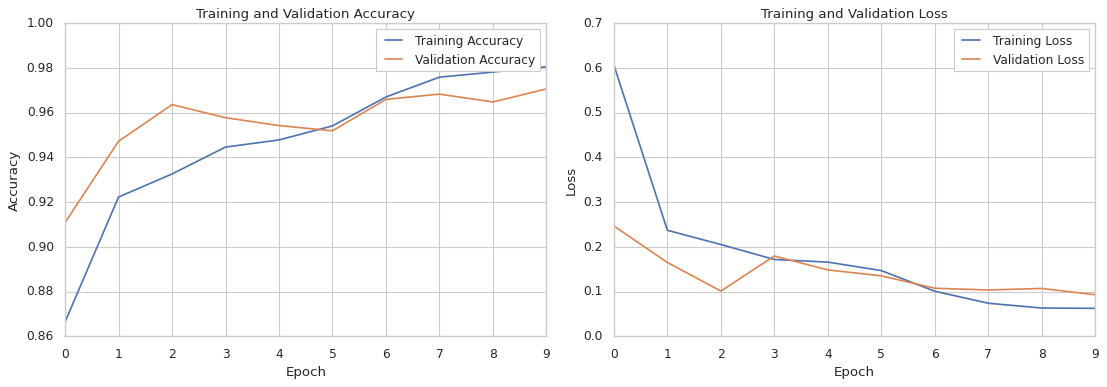

In [ ]:
# Mengambil data dari history
history_val = history.history

# Plot akurasi untuk Validation Dataset
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_val['accuracy'], label='Training Accuracy')
plt.plot(history_val['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot kehilangan (loss) untuk Validation Dataset
plt.subplot(1, 2, 2)
plt.plot(history_val['loss'], label='Training Loss')
plt.plot(history_val['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# # Menghitung akurasi untuk Validation Dataset
# Acc_val = accuracy_score(y_val, y_pred_val)
# print("Validation accuracy is: {0:.4f}%".format(Acc_val * 100))

# # Evaluasi model untuk Validation Dataset
# print("Classification Report (Validation Dataset):\n", classification_report(y_val, y_pred_val))

In [ ]:
# # Set the figure size untuk Confusion Matrix Validation Dataset
# plt.figure(figsize=(17, 10))
# ax = plt.subplot()
# CM_val = confusion_matrix(y_val, y_pred_val)
# sns.heatmap(CM_val, annot=True, fmt='g', ax=ax, cbar=False, cmap='RdBu')
# ax.set_xlabel('Predicted labels')
# ax.set_ylabel('True labels')
# ax.set_title('Confusion Matrix (Validation Dataset)')
# plt.show()

In [ ]:
# # Menghitung metrik evaluasi untuk Validation Dataset
# precision_val = precision_score(y_val, y_pred_val, average='weighted')  # Menggunakan average='weighted'
# recall_val = recall_score(y_val, y_pred_val, average='weighted')  # Menggunakan average='weighted'
# f1_val = f1_score(y_val, y_pred_val, average='weighted')  # Menggunakan average='weighted'
# conf_matrix_val = confusion_matrix(y_val, y_pred_val)
# balanced_accuracy_val = balanced_accuracy_score(y_val, y_pred_val)

# # Mencetak hasil evaluasi untuk Validation Dataset
# print("Evaluasi Model (Validation Dataset):")
# print("------------------")
# print(f"Precision         : {precision_val:.5f}")
# print(f"Recall            : {recall_val:.5f}")
# print(f"F1-Score          : {f1_val:.5f}")
# print(f"Balanced Accuracy : {balanced_accuracy_val:.5f}")
# print("------------------")

### Data Test

In [ ]:
# Evaluasi Model untuk Test Dataset
score_test, acc_test = model.evaluate(test_generator)
print(f'Test Loss = {score_test}')
print(f'Test Accuracy = {acc_test}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 438ms/step - accuracy: 0.9664 - loss: 0.1243
Test Loss = 0.12532730400562286
Test Accuracy = 0.9701896905899048


In [ ]:
# # Validation Predictions - Menggunakan Generator untuk Batch Prediction
# y_test, y_pred_test = [], []

# for images, labels in validation_generator:
#     y_test.extend(labels)  # No need for .numpy(), labels is already a numpy array
#     predictions = model.predict(images)  # Prediksi untuk batch ini
#     y_pred_test.extend(np.argmax(predictions, axis=1))

# # Membuat DataFrame untuk Actual vs Prediction
# df_test = pd.DataFrame()
# df_test['Actual'], df_test['Prediction'] = y_test, y_pred_test
# display(df_test)

In [ ]:
# # Menghitung akurasi untuk Test Dataset
# Acc_test = accuracy_score(y_test, y_pred_test)
# print("accuracy is: {0:.4f}%".format(Acc_test * 100))

# # Evaluasi model untuk Test Dataset
# print("Classification Report (Test Dataset):\n", classification_report(y_test, y_pred_test))

In [ ]:
# # Set the figure size untuk Confusion Matrix
# plt.figure(figsize=(17, 10))
# ax = plt.subplot()
# CM_test = confusion_matrix(y_test, y_pred_test)
# sns.heatmap(CM_test, annot=True, fmt='g', ax=ax, cbar=False, cmap='RdBu')
# ax.set_xlabel('Predicted labels')
# ax.set_ylabel('True labels')
# ax.set_title('Confusion Matrix (Test Dataset)')
# plt.show()

In [ ]:
# # Menghitung metrik evaluasi untuk Test Dataset
# precision_test = precision_score(y_test, y_pred_test, average='weighted')  # Menggunakan average='weighted'
# recall_test = recall_score(y_test, y_pred_test, average='weighted')  # Menggunakan average='weighted'
# f1_test = f1_score(y_test, y_pred_test, average='weighted')  # Menggunakan average='weighted'
# conf_matrix_test = confusion_matrix(y_test, y_pred_test)
# balanced_accuracy_test = balanced_accuracy_score(y_test, y_pred_test)

# # Mencetak hasil evaluasi untuk Test Dataset
# print("Evaluasi Model (Test Dataset):")
# print("------------------")
# print(f"Precision         : {precision_test:.5f}")
# print(f"Recall            : {recall_test:.5f}")
# print(f"F1-Score          : {f1_test:.5f}")
# print(f"Balanced Accuracy : {balanced_accuracy_test:.5f}")
# print("------------------")

In [ ]:
tf.keras.utils.plot_model(model, to_file='Current_model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=100)
tf.keras.utils.plot_model(base_model, to_file='Base_model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=100)

## Saving Model

### Format SavedModel: Standart TensorFlow

In [ ]:
# Define the path to save the model in Google Drive
# Make sure your Google Drive is mounted at '/content/drive'
tf_model_path = '/content/drive/MyDrive/Colab Notebooks/GarbageClassification.h5'
os.makedirs(os.path.dirname(tf_model_path), exist_ok=True)

# Exclude the custom callback when saving the model
# You might need to reinstantiate the model and train it again if you want to save it later with the custom callback
# or refactor the custom callback to be serializable.
# model.fit(
#     train_generator,
#     epochs = 35,
#     validation_data= validation_generator,
#     callbacks=[
#         keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=2, restore_best_weights=True),
#         keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, verbose=2, min_lr=1e-6)
#     ],
#     class_weight=class_weight_dict
# )

model.save(tf_model_path)

In [ ]:
# Save the model in Keras format to Google Drive
model.save('/content/drive/MyDrive/Colab Notebooks/GarbageClassification.keras', save_format='keras')

## Konversi Model

### Format TFJS: TensorFlow.js

In [ ]:
!tensorflowjs_converter \
    --input_format=keras \
    /content/drive/MyDrive/Colab Notebooks/GarbageClassification.keras \
    /kaggle/working/modeltfjs

2025-10-20 02:42:58.085429: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760928178.111975   16876 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760928178.118033   16876 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760928178.138393   16876 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760928178.138420   16876 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760928178.138426   16876 computation_placer.cc:177] computation placer alr

### Format TFLite: Tensorflow Lite

In [ ]:
# Konversi ke TensorFlow Lite
tflite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tflite_converter.convert()

# Membuat folder tflite jika belum ada
tflite_directory = '/kaggle/working/tflite'
if not os.path.exists(tflite_directory):
    os.makedirs(tflite_directory)


# Menyimpan model TFLite di folder tflite
tflite_output_path = tflite_directory + '/model.tflite'
with open(tflite_output_path, "wb") as f:
    f.write(tflite_model)

In [ ]:
# Fungsi untuk menghasilkan labels.txt
def recreate_labels(dataset_directory, output_file):
    # Ambil nama folder yang ada dalam direktori dataset
    labels = [folder for folder in os.listdir(dataset_directory) if not folder.startswith('.')]

    # Tulis nama kelas ke dalam file labels.txt
    with open(output_file, 'w') as file:
        for label in labels:
            file.write(label + '\n')  # Memastikan setiap label dipisah dengan newline

# Panggil fungsi untuk membuat file labels.txt
recreate_labels(dataset_directory = train_dir, output_file= tflite_directory + '/labels.txt')

print("Konversi TFLite dan pembuatan labels.txt berhasil.")

## Inference (Optional)

### TF-Saved Model

In [ ]:
# Path to the saved model in Google Drive
tf_model_path = '/content/drive/MyDrive/GarbageClassification.h5'
loaded_model = tf.keras.models.load_model(tf_model_path) # Load with tf.keras.models.load_model for HDF5 format

In [ ]:
# Example for inference if the model has a default serving signature:
# infer = loaded_model.signatures["serving_default"] # Remove this line

def images_preprocessing(filename):
    image = tf.io.decode_image(open(filename, 'rb').read(), channels=3)  # Membaca dan decode gambar
    image = tf.image.resize(image, [299, 299])  # Resize gambar ke ukuran yang sesuai dengan model
    image = image / 255.0  # Normalisasi gambar

    image_tensor = tf.expand_dims(image, 0)  # Tambahkan dimensi batch
    return image_tensor

In [ ]:
# Nama file gambar untuk inferensi
filename = '/kaggle/working/garbage-classification-merged/glass/glass1002.jpg'
image_tensor = images_preprocessing(filename=filename)

In [ ]:
# Lakukan inferensi
predictions = loaded_model(image_tensor)  # Menggunakan model untuk prediksi

# Mendapatkan kelas dengan probabilitas tertinggi
predicted_class = tf.argmax(predictions[0]).numpy()
print(f'Predicted class: {predicted_class}')

In [ ]:
# Mapping label
map_labels = {
        0: "fabric",
        1: "glass",
        2: "non-recyclable",
        3: "paper",
        4: "recyclable-inorganic"
    }

# Buka gambar
img = Image.open(filename)

# Tampilkan gambar
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


print("Prediksi: ", map_labels[predicted_class])

### Using TensorFlow Lite

In [ ]:
# Load the TFLite model and allocate tensors.
import tensorflow as tf
interpreter = tf.lite.Interpreter(model_path= tflite_directory + '/model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Get input shape
input_shape = input_details[0]['shape']

In [ ]:
# Konversi ke TensorFlow Lite
tflite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tflite_converter.convert()

# Membuat folder tflite jika belum ada
tflite_directory = '/kaggle/working/tflite'
if not os.path.exists(tflite_directory):
    os.makedirs(tflite_directory)


# Menyimpan model TFLite di folder tflite
tflite_output_path = tflite_directory + '/model.tflite'
with open(tflite_output_path, "wb") as f:
    f.write(tflite_model)

print("TFLite model saved successfully at:", tflite_output_path)

In [ ]:
def preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize to [0, 1] as done during training
    return img_array

# Contoh penggunaan
img_path = '/kaggle/working/garbage-classification-merged/fabric/fabric1025.jpg'
input_data = preprocess_image(img_path, target_size=(299, 299))

In [ ]:
# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run the inference
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])
print("Raw Output:", output_data)

Raw Output: [[9.9998057e-01 7.0120301e-08 4.1747165e-07 1.8885545e-05 5.8880214e-08]]


In [ ]:
class_names = [
    "fabric",
    "glass",
    "non-recyclable",
    "paper",
    "recyclable-inorganic"
]


# Get the predicted class
predicted_class = np.argmax(output_data, axis=1)
predicted_class_name = class_names[predicted_class[0]]

print(f"Predicted Class: {predicted_class_name}")

In [ ]:
def predict_image_tflite(model_path, img_path, class_names, target_size=(299, 299)):
    # Load the TFLite model and allocate tensors.
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Preprocess the image
    input_data = preprocess_image(img_path, target_size)

    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Run the inference
    interpreter.invoke()

    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Get the predicted class
    predicted_class = np.argmax(output_data, axis=1)
    predicted_class_name = class_names[predicted_class[0]]

    return predicted_class_name

# Contoh penggunaan
path_image = '/kaggle/working/garbage-classification-merged/paper/paper1002.jpg'
path_model_to_load = tflite_directory + '/model.tflite'

# Buka gambar
img = Image.open(path_image)

# Tampilkan gambar
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

predicted_class_name = predict_image_tflite(path_model_to_load, path_image, class_names)
print(f"Predicted Class: {predicted_class_name}")

## Just Trying to Many Data

In [ ]:
# # Menampilkan input dan output dari signature default
# print("Input Signature:")
# for input_name, input_tensor in infer.structured_input_signature[1].items():
#     print(f"{input_name}: {input_tensor}")

# print("\nOutput Signature:")
# for output_name, output_tensor in infer.structured_outputs.items():
#     print(f"{output_name}: {output_tensor}")

In [ ]:
# Fungsi untuk memuat dan memproses gambar
def preprocess_image(img_path, target_size=(299, 299)):
    img = Image.open(img_path)
    img = img.resize(target_size)  # Resize gambar
    img_array = np.array(img)  # Mengubah gambar menjadi array numpy
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch
    img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)  # Ubah menjadi tensor
    img_array /= 255.0  # Normalisasi ke [0, 1]
    return img_array

# Fungsi untuk memproses dan melakukan prediksi pada gambar dalam folder
def predict_folder(model, folder_path, target_size=(299, 299)):
    results = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Filter hanya gambar
            image_path = os.path.join(folder_path, filename)
            image_tensor = preprocess_image(image_path, target_size)  # Proses gambar
            # Gunakan salah satu metode prediksi sesuai kebutuhan (softmax atau logit)
            predicted_class, confidence = predict_with_logit_confidence(model, image_tensor)  # Ganti jika perlu
            results.append((filename, predicted_class, confidence))

    return results

# Fungsi untuk melakukan prediksi dengan confidence score (menggunakan logits)
def predict_with_logit_confidence(model, image_tensor):
    # Lakukan prediksi menggunakan model
    predictions = model(image_tensor)  # Model mengharapkan input berupa tensor

    # Ambil logit langsung dari output
    logits = predictions['output_0']

    # Mendapatkan kelas dengan logit tertinggi dan confidence score (logit tertinggi - logit terendah)
    predicted_class = tf.argmax(logits, axis=-1).numpy()
    confidence = (tf.reduce_max(logits, axis=-1) - tf.reduce_min(logits, axis=-1)).numpy()

    return predicted_class[0], confidence[0]

# Fungsi untuk menampilkan gambar dan hasil prediksi
def display_predictions_with_images(folder_path, model, map_labels, actual_labels, num_images=5):
    # Dapatkan hasil prediksi untuk gambar-gambar dalam folder
    results = predict_folder(model, folder_path)

    # Tentukan jumlah gambar yang akan ditampilkan
    num_images = min(num_images, len(results))

    # Buat subplot
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))  # Menampilkan gambar dalam satu baris
    if num_images == 1:  # Jika hanya satu gambar, pastikan axes tetap bisa diiterasi
        axes = [axes]

    # Loop untuk menampilkan gambar, hasil prediksi, dan confidence score
    for i in range(num_images):
        filename, predicted_class, confidence = results[i]

        # Path ke gambar
        img_path = os.path.join(folder_path, filename)

        # Muat gambar
        img = image.load_img(img_path, target_size=(224, 224))  # Ganti dengan ukuran input model Anda
        img_array = image.img_to_array(img) / 255.0  # Normalisasi gambar jika diperlukan
        img_array = np.expand_dims(img_array, axis=0)  # Sesuaikan dimensi untuk prediksi

        # Ambil label sebenarnya dari file (misalnya menggunakan nama folder atau file)
        actual_class = actual_labels.get(filename, "Unknown")  # Ganti sesuai kebutuhan

        # Plot gambar dan hasil prediksi di subplot
        axes[i].imshow(img)
        axes[i].axis('off')  # Nonaktifkan axis

        # Tampilkan prediksi dan probabilitas
        axes[i].set_title(f"Pred: {map_labels[predicted_class]}\nConf: {confidence:.4f}\nActual: {actual_class}")

    plt.tight_layout()
    plt.show()

In [ ]:
source_dir = "/kaggle/input/unseen-data"
# Destination directory
destination_dir = "/kaggle/working/inference data"

shutil.copytree(source_dir, destination_dir)

In [ ]:
folder_path = "/kaggle/working/inference data/Unseen Data"
# Path to the saved model in Google Drive
model_path = '/content/drive/MyDrive/GarbageClassification.h5'

# Load the TensorFlow model (e.g., SavedModel)
loaded_model = tf.keras.models.load_model(model_path)  # Load with tf.keras.models.load_model for HDF5 format
infer = loaded_model.signatures["serving_default"]

# Mapping label for the classes in the model
map_labels = {
    0: "fabric",
    1: "glass",
    2: "non-recyclable",
    3: "paper",
    4: "recyclable-inorganic"
}

# Actual labels used for verification (replace with your actual labels)
actual_labels = {
    "fabric.jpeg": "fabric",
    "glass.jpeg": "glass",
    "paper.jpeg": "paper",
    "non-recyclable.jpeg": "non-recyclable",
    "recyclable-inorganic.jpg": "recyclable-inorganic"
}

# Display prediction results
display_predictions_with_images(folder_path, infer, map_labels, actual_labels)

# Make requirements.txt

In [ ]:
!pip freeze > /kaggle/working/requirements.txt